In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import xgboost as xgb
import copy

pd.set_option('display.max_rows', 1000)

In [2]:
burn_data = pd.read_csv('/Users/jeremybalch/Dropbox (UFL)/Projects/Burn/data/burn_full_v2.csv')

In [3]:
burn_data.head()

,Column1,Study_ID,Transfused,Age,TBSA,2nd_degree,3rd_degree,ICU_LOS,Hosp_LOS,Dispo,...,Preop_Hb,Excised,Grafted,Case_length_minutes,RBC_Volume,FFP_Volume,Plt_Volume,Cryo_Volume,Total_blood_volume_transfused,RTOR
0,153,1140-034,0,35,11.0,10.00,1.00,0,5,1,...,13.5,0.0,0,86,0,0,0,0,0,1
1,142,1140-016,0,44,1.0,0.00,1.00,0,3,1,...,13.3,1.0,1,64,0,0,0,0,0,1
2,252,17,0,57,0.5,0.25,0.25,0,7,1,...,NaN,5.0,4,47,0,0,0,0,0,2
3,180,1140-067,0,66,1.0,0.00,1.00,0,1,1,...,14.6,8.0,8,64,0,0,0,0,0,1
4,226,4,0,41,0.5,0.00,0.50,0,3,1,...,NaN,15.0,15,41,0,0,0,0,0,1


## Exploratory Data Analysis

In [45]:

# df = burn_data.copy()
# profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file('/Users/jeremybalch/Desktop/burn_report.html')

## Preprocessing - Multiclass Classification Project

In [46]:
# Select relevant columns
X_clean = burn_data[['Age', 'Hosp_LOS', '2nd_degree', '3rd_degree', 'Preop_Hb', 'Excised', 'Grafted', 'Case_length_minutes', 'RTOR']]
y_clean = burn_data['Transfused']

In [47]:
# Assuming X_clean is your features and y_clean is the target variable (RBC_units)
# First, split into training (60%) and temporary data (40%) with stratification
train_X, temp_X, train_y, temp_y = train_test_split(X_clean, y_clean, test_size=0.4, stratify=y_clean, random_state=42)

# Now, split the temporary data into validation (20%) and test (20%) sets with stratification
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

In [48]:
# Impute Missing Values

#Instantiate the imputer
mice_imputer = IterativeImputer(random_state=42)

# Apply MICE imputation on train data for the specified columns
train_X[['Preop_Hb', 'Excised']] = mice_imputer.fit_transform(train_X[['Preop_Hb', 'Excised']])

# Apply MICE imputation on validation and test data for the specified columns
val_X[['Preop_Hb', 'Excised']] = mice_imputer.transform(val_X[['Preop_Hb', 'Excised']])
test_X[['Preop_Hb', 'Excised']] = mice_imputer.transform(test_X[['Preop_Hb', 'Excised']])

In [49]:
# Instantiate the scaler
scaler = StandardScaler()

# Fit on training data and transform it
train_X_scaled = scaler.fit_transform(train_X)

# Only transform the validation and test data
val_X_scaled = scaler.transform(val_X)
test_X_scaled = scaler.transform(test_X)

# Models

###     Decision Tree

In [50]:
# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': list(range(1, 21)),
    'criterion': ['gini', 'entropy'],
    'max_features': list(range(1, train_X_scaled.shape[1] + 1)) + ['auto', 'sqrt', 'log2']
}

# Instantiate the decision tree classifier
tree = DecisionTreeClassifier(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the model to the training data
grid_search.fit(train_X_scaled, train_y)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.

In [51]:
print(best_params)
print(best_score)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 6}
0.9406451612903226


In [52]:
# Instantiate the model with the best hyperparameters
best_tree = DecisionTreeClassifier(**best_params, random_state=42)
best_tree.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions = best_tree.predict(val_X_scaled)
val_accuracy = accuracy_score(val_y, val_predictions)

# Evaluate on the test set
test_predictions_tree = best_tree.predict(test_X_scaled)
test_accuracy = accuracy_score(test_y, test_predictions_tree)

val_accuracy, test_accuracy


(0.8823529411764706, 0.8627450980392157)

### k-nearest neighbors

In [53]:
from sklearn.neighbors import KNeighborsClassifier

# Define the hyperparameters and their possible values
param_grid_knn = {
    'n_neighbors': list(range(1, 51)),  # testing values of k from 1 to 50
    'weights': ['uniform', 'distance'],  # uniform weights vs inverse distance weighting
    'metric': ['euclidean', 'manhattan']  # distance metrics
}

# Instantiate the kNN classifier
knn = KNeighborsClassifier()

# Set up grid search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', return_train_score=True)

# Note: Replace "train_X_scaled" and "train_y" with your actual scaled training data and labels
grid_search_knn.fit(train_X_scaled, train_y)

# Get the best parameters from the grid search
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

best_params_knn, best_score_knn



({'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'},
 0.9470967741935485)

In [54]:
# Instantiate the kNN model with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params_knn)
best_knn.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions_knn = best_knn.predict(val_X_scaled)
val_accuracy_knn = accuracy_score(val_y, val_predictions_knn)

# Evaluate on the test set
test_predictions_knn = best_knn.predict(test_X_scaled)
test_accuracy_knn = accuracy_score(test_y, test_predictions_knn)

val_accuracy_knn, test_accuracy_knn


(0.8823529411764706, 0.8627450980392157)

### SVM

In [55]:
from sklearn.svm import SVC

# Define the hyperparameters and their possible values
param_grid_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # only relevant for 'poly' kernel
    'gamma': ['scale', 'auto']
}

# Instantiate the SVM classifier
svm = SVC(random_state=42)

# Set up grid search with cross-validation
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', return_train_score=True)

# Note: Replace "train_X_scaled" and "train_y" with your actual scaled training data and labels
grid_search_svm.fit(train_X_scaled, train_y)

# Get the best parameters from the grid search
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_

best_params_svm, best_score_svm



({'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}, 0.9535483870967741)

In [56]:
# Instantiate the SVM model with the best hyperparameters
best_svm = SVC(**best_params_svm)
best_svm.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions_svm = best_svm.predict(val_X_scaled)
val_accuracy_svm = accuracy_score(val_y, val_predictions_svm)

# Evaluate on the test set
test_predictions_svm = best_svm.predict(test_X_scaled)
test_accuracy_svm = accuracy_score(test_y, test_predictions_svm)

val_accuracy_svm, test_accuracy_svm


(0.8823529411764706, 0.8627450980392157)

### Xgboost 

In [57]:


# # Define the hyperparameters and their possible values
# param_grid_xgb = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 4, 5, 6],  # smaller depths as part of aggressive pruning
#     'subsample': [0.7, 0.8, 0.9, 1],
#     'colsample_bytree': [0.7, 0.8, 0.9, 1],
#     'n_estimators': [50, 100, 150],
#     'objective': ['binary:logistic'],  # assuming multiclass classification
#     'gamma': [0, 0.1, 0.2]
# }

# # Instantiate the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# # Set up grid search with cross-validation
# grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, cv=5, scoring='accuracy', return_train_score=True)

# grid_search_xgb.fit(train_X_scaled, train_y)

# # Get the best parameters from the grid search
# best_params_xgb = grid_search_xgb.best_params_
# best_score_xgb = grid_search_xgb.best_score_

# # Uncomment the above lines and execute them on your actual dataset to get the best hyperparameters and their accuracy.
# best_params_xgb, best_score_xgb



In [58]:
best_params_xgb = {
    'colsample_bytree': 0.7,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_depth': 4,
    'n_estimators': 150,
    'objective': 'binary:logistic',
    'subsample': 0.8
}


In [59]:
# Instantiate the XGBoost model with the best hyperparameters
best_xgb = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
best_xgb.fit(train_X_scaled, train_y)

# Evaluate on the validation set
val_predictions_xgb = best_xgb.predict(val_X_scaled)
val_accuracy_xgb = accuracy_score(val_y, val_predictions_xgb)

# Evaluate on the test set
test_predictions_xgb = best_xgb.predict(test_X_scaled)
test_accuracy_xgb = accuracy_score(test_y, test_predictions_xgb)

val_accuracy_xgb, test_accuracy_xgb


`use_label_encoder` is deprecated in 1.7.0.


(0.9019607843137255, 0.8627450980392157)

### Neural Network

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim


In [61]:
# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)  # Second fully connected layer
        self.fc3 = nn.Linear(64, output_dim)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming a binary classification task; adjust the number of classes if it's a multiclass problem
input_dim = train_X_scaled.shape[1]
output_dim = 2  # for binary classification

# Convert data to PyTorch tensors
train_X_tensor = torch.tensor(train_X_scaled, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y, dtype=torch.long)
val_X_tensor = torch.tensor(val_X_scaled, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.values, dtype=torch.long)

# Instantiate the model, loss function, and optimizer
model = SimpleNN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [62]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pth'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pth'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [63]:
# Initialize the EarlyStopping class
early_stopping = EarlyStopping(patience=10, verbose=True)

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_X_tensor)
    loss = criterion(outputs, train_y_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Compute the validation loss
    with torch.no_grad():
        val_outputs = model(val_X_tensor)
        val_loss = criterion(val_outputs, val_y_tensor)

    # Call EarlyStopping
    early_stopping(val_loss, model)

    # Break out of the loop if early stopping condition is met
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

# Evaluate the model on the validation set
with torch.no_grad():
    val_outputs = model(val_X_tensor)
    _, predicted = torch.max(val_outputs.data, 1)
    val_accuracy = (predicted == val_y_tensor).sum().item() / val_y_tensor.size(0)
    print(f'Validation Accuracy: {val_accuracy:.4f}')


Validation loss decreased (inf --> 0.695084).  Saving model ...
Validation loss decreased (0.695084 --> 0.669974).  Saving model ...
Validation loss decreased (0.669974 --> 0.646643).  Saving model ...
Validation loss decreased (0.646643 --> 0.624749).  Saving model ...
Validation loss decreased (0.624749 --> 0.603864).  Saving model ...
Validation loss decreased (0.603864 --> 0.584090).  Saving model ...
Validation loss decreased (0.584090 --> 0.565009).  Saving model ...
Validation loss decreased (0.565009 --> 0.546535).  Saving model ...
Validation loss decreased (0.546535 --> 0.528298).  Saving model ...
Validation loss decreased (0.528298 --> 0.510560).  Saving model ...
Epoch [10/100], Training Loss: 0.5275, Validation Loss: 0.5106
Validation loss decreased (0.510560 --> 0.493153).  Saving model ...
Validation loss decreased (0.493153 --> 0.476164).  Saving model ...
Validation loss decreased (0.476164 --> 0.459561).  Saving model ...
Validation loss decreased (0.459561 --> 0.443

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define a function to compute metrics
def compute_metrics(true_values, predicted_values):
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values)
    recall = recall_score(true_values, predicted_values)
    f1 = f1_score(true_values, predicted_values)
    auc = roc_auc_score(true_values, predicted_values)
    
    return accuracy, precision, recall, f1, auc

# Example: Compute metrics for each model
metrics_decision_tree = compute_metrics(test_y, test_predictions_tree)  # replace with your actual predictions
metrics_knn = compute_metrics(test_y, test_predictions_knn)
metrics_svm = compute_metrics(test_y, test_predictions_svm)
metrics_xgb = compute_metrics(test_y, test_predictions_xgb)

# For PyTorch Neural Network
with torch.no_grad():
    nn_outputs = model(torch.tensor(test_X_scaled, dtype=torch.float32))
    _, nn_predictions = torch.max(nn_outputs.data, 1)
    nn_predictions = nn_predictions.numpy()
metrics_nn = compute_metrics(test_y, nn_predictions)

# Compile metrics into a table
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Decision Tree': metrics_decision_tree,
    'KNN': metrics_knn,
    'SVM': metrics_svm,
    'XGBoost': metrics_xgb,
    'Neural Network': metrics_nn
})

metrics_table


,Metric,Decision Tree,KNN,SVM,XGBoost,Neural Network
0,Accuracy,0.862745,0.862745,0.862745,0.862745,0.901961
1,Precision,0.833333,0.875000,0.833333,0.852941,0.906250
2,Recall,0.967742,0.903226,0.967742,0.935484,0.935484
3,F1 Score,0.895522,0.888889,0.895522,0.892308,0.920635
4,AUC,0.833871,0.851613,0.833871,0.842742,0.892742


In [65]:
metrics_table.to_csv('/Users/jeremybalch/Desktop/metrics_binary.csv')


In [66]:
# Instantiate models with best hyperparameters

best_knn = KNeighborsClassifier(metric='euclidean', n_neighbors=5, weights='uniform')

best_svm = SVC(C=1, degree=2, gamma='scale', kernel='rbf', probability=True)  # probability=True is needed for calculating some metrics later if required.

best_xgb = xgb.XGBClassifier(colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=4, 
                             n_estimators=150, objective='binary:logistic', subsample=0.8, use_label_encoder=False)


`use_label_encoder` is deprecated in 1.7.0.


`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecate

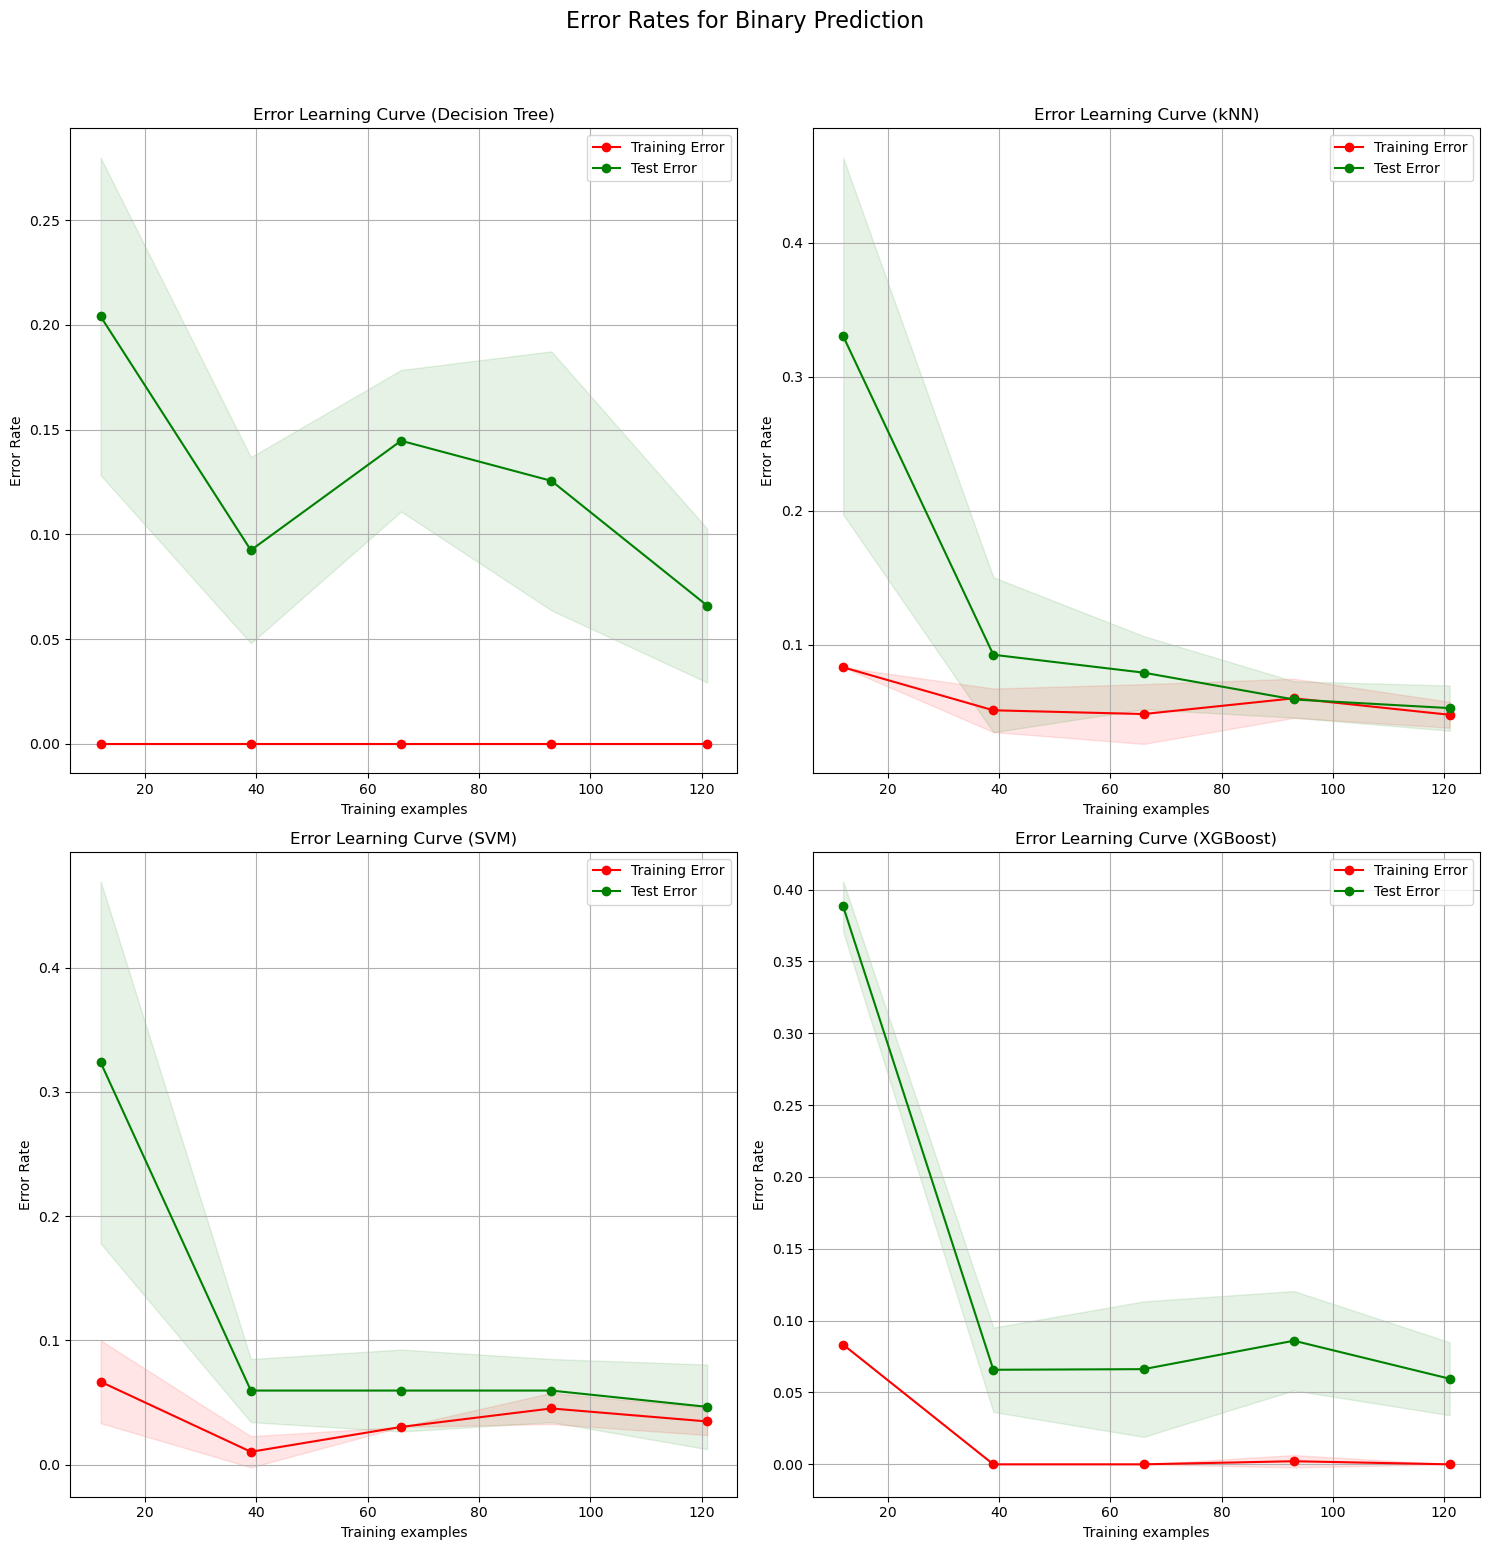

In [67]:
def plot_error_learning_curve_subplot(ax, estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Error Rate")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Convert scores to error rates
    train_error_rates = 1 - np.mean(train_scores, axis=1)
    test_error_rates = 1 - np.mean(test_scores, axis=1)
    
    train_std = np.std(train_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    ax.grid()
    
    ax.fill_between(train_sizes, train_error_rates - train_std, train_error_rates + train_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_error_rates - test_std, test_error_rates + test_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_error_rates, 'o-', color="r", label="Training Error")
    ax.plot(train_sizes, test_error_rates, 'o-', color="g", label="Test Error")
    
    ax.legend(loc="best")

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot error learning curves in 2x2 subplots
plot_error_learning_curve_subplot(axs[0, 0], best_tree, "Error Learning Curve (Decision Tree)", train_X_scaled, train_y, cv=5)
plot_error_learning_curve_subplot(axs[0, 1], best_knn, "Error Learning Curve (kNN)", train_X_scaled, train_y, cv=5)
plot_error_learning_curve_subplot(axs[1, 0], best_svm, "Error Learning Curve (SVM)", train_X_scaled, train_y, cv=5)
plot_error_learning_curve_subplot(axs[1, 1], best_xgb, "Error Learning Curve (XGBoost)", train_X_scaled, train_y, cv=5)

fig.suptitle("Error Rates for Binary Prediction", fontsize=16, y=1.03)
plt.tight_layout()
plt.show()


In [68]:
feature_labels = X_clean.columns.tolist()

In [69]:
import shap

# Initialize the JS visualization code
shap.initjs()
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(val_X_scaled[:100])
shap.summary_plot(shap_values, val_X_scaled[:100], feature_names=feature_labels, plot_type='dot', color='coolwarm')


NotFittedError: need to call fit or load_model beforehand